# CS 3500 - The Model 🧠

## Import Libraries 📚

In [59]:
# For Machine Learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import WeightedRandomSampler

# For Data Visualization & Loss Tracking
import matplotlib.pyplot as plt

# To Read-In Data
import pandas as pd

# To Track Training Progress
from tqdm import tqdm

# For Scalers and Metrics
from sklearn.preprocessing import PowerTransformer

## Read-In And Examine Cleaned Dataset 👀

In [60]:
combined_df = pd.read_csv('../Data/Clean/Clean_Combined.csv')

# Split Data
def split_data(df, n_test=0.2, shuffle=True):
    if shuffle:
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    test_size = int(n_test * len(df))
    train_size = len(df) - test_size

    train = df[:train_size]
    test = df[train_size:]
    return train, test

train, test = split_data(combined_df)
print("Length Of Train", len(train))
print("Length Of Test", len(test))

Length Of Train 189451
Length Of Test 47362


In [61]:
# Forgot to drop mo_codes --> Drop mo_codes as data has been extracted
train.drop(columns = "mo_codes", axis = 1, inplace = True)
train.head()

,DR_NO,area_code,reporting_district,crime_part,crime_code,victim_age,premise_code,weapon_code,days_to_holiday,report_year,...,occ_time_interval_06:01-12:00,occ_time_interval_12:01-18:00,occ_time_interval_18:01-24:00,occurrence_time_of_day_Afternoon,occurrence_time_of_day_Early Morning,occurrence_time_of_day_Evening,occurrence_time_of_day_Late Night,occurrence_time_of_day_Morning,occurrence_time_of_day_Night,Status
0,231911685,19,1959,1,331,48,101.0,0.0,8,2023,...,False,False,True,False,False,False,False,False,True,2
1,232018937,20,2026,1,230,26,101.0,302.0,10,2023,...,False,False,False,False,False,False,True,False,False,2
2,240408251,4,412,1,330,27,504.0,0.0,19,2024,...,False,False,True,False,False,False,False,False,True,2
3,231910450,19,1974,2,930,35,502.0,511.0,14,2023,...,False,False,True,False,False,False,False,False,True,0
4,230306036,3,375,2,354,50,501.0,0.0,17,2023,...,False,False,False,False,False,False,True,False,False,2


In [62]:
test.drop(columns = "mo_codes", axis = 1, inplace = True)
test.head()

,DR_NO,area_code,reporting_district,crime_part,crime_code,victim_age,premise_code,weapon_code,days_to_holiday,report_year,...,occ_time_interval_06:01-12:00,occ_time_interval_12:01-18:00,occ_time_interval_18:01-24:00,occurrence_time_of_day_Afternoon,occurrence_time_of_day_Early Morning,occurrence_time_of_day_Evening,occurrence_time_of_day_Late Night,occurrence_time_of_day_Morning,occurrence_time_of_day_Night,Status
189451,230107790,1,155,2,626,46,502.0,400.0,7,2023,...,False,True,False,False,False,True,False,False,False,1
189452,230915076,9,985,1,330,40,101.0,0.0,2,2023,...,False,True,False,False,False,True,False,False,False,2
189453,230905250,9,923,2,664,80,102.0,0.0,15,2023,...,False,False,True,False,False,True,False,False,False,1
189454,231312969,13,1331,1,230,53,101.0,106.0,6,2023,...,False,False,False,False,False,False,True,False,False,2
189455,231318728,13,1317,2,624,19,935.0,400.0,1,2023,...,False,True,False,True,False,False,False,False,False,2


In [63]:
train.info() # All datatypes float, int, boolean --> We are now able to move on

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189451 entries, 0 to 189450
Columns: 601 entries, DR_NO to Status
dtypes: bool(560), float64(2), int64(39)
memory usage: 160.4 MB


## Define Features/Target And Perform Light Preprocessing ♻️
* We Are Scaling Features since the dataset contains 0 values to values in the millions! This can affect the performance of our model.
   

In [64]:
# Define Target Cols And Features - Train
train_features = train.drop(columns="Status")
train_target = train["Status"]

# Define Target Cols And Features - Test
test_features = test.drop(columns = "Status")
test_target = test["Status"]

# Scale Features
feature_scaler = PowerTransformer(method='yeo-johnson')
scaled_train_features = feature_scaler.fit_transform(train_features)
scaled_test_features = feature_scaler.fit_transform(test_features)

## Create DataLoaders (*Convert Pandas DF To Tensors*) ⚙️

In [65]:
class Crime_Dataset(Dataset):
    def __init__(self, features, targets):
        # Conver to Torch Tensors
        self.x = torch.tensor(features, dtype = torch.float32)
        self.y = torch.tensor(targets.values, dtype = torch.float32)

    # Define mandatory length method
    def __len__(self):
        return len(self.y)
    
    # Define mandatory get item method
    def __getitem__(self, index):
        return self.x[index], self.y[index]

# Instantiate Class With Data
train_df = Crime_Dataset(scaled_train_features, train_target)
test_df = Crime_Dataset(scaled_test_features, test_target)

In [66]:
# Compute sample weights based on inverse class frequency
class_counts = train_target.value_counts().to_dict()
weights = {k: 1.0 / v for k, v in class_counts.items()}
sample_weights = train_target.map(weights)

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Prepare Data Loaders
train = DataLoader(train_df, batch_size=64, sampler = sampler)
test = DataLoader(test_df, batch_size = 64, shuffle = False)

In [67]:
# Check splits and number of batches
print("Training Samples: ", len(train_df))
print("Testing Samples: ", len(test_df))
print("Number of Training Batches: ", len(train))
print("Number of Testing Batches: ", len(test))

Training Samples:  189451
Testing Samples:  47362
Number of Training Batches:  2961
Number of Testing Batches:  741


## Build The Model 🧱

In [68]:
class Model(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Model, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveMaxPool1d(1)

        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch, 1, 600)
        x = self.relu(self.conv1d(x))  # (batch, 64, 600)
        x = self.pool(x)               # (batch, 64, 1)
        x = x.squeeze(-1)              # (batch, 64)

        x = self.relu(self.fc1(x))     # (batch, 128)
        x = self.relu(self.fc2(x))     # (batch, 256)
        x = self.fc3(x)                # (batch, num_classes)
        return x

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [34:47<00:00, 20.88s/it]


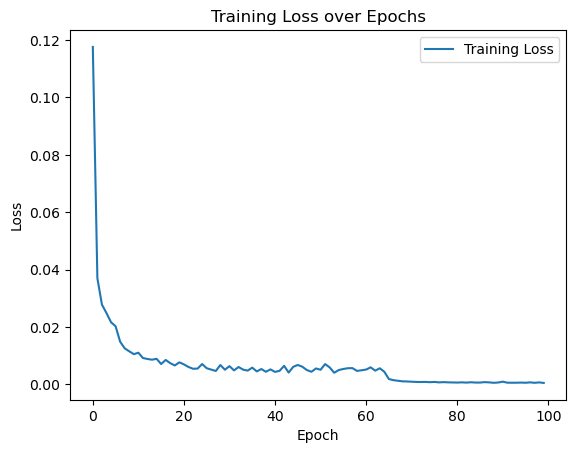

In [69]:
# Define Static Shapes
input_size = scaled_train_features.shape[1] # Number of Columns
num_classes = 5
epochs = 100

# Compute class weights
classes = np.array(sorted(train_target.unique()))
class_weights = compute_class_weight(class_weight = 'balanced', classes = classes, y = train_target)
class_weights = torch.tensor(class_weights, dtype = torch.float32)

# Initialize Model
model = Model(input_size, num_classes) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight = class_weights)

# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

# Training and validation loss tracking
loss_values = []

# Set Model To 'Train' Mode
model.train()
for epoch in tqdm(range(epochs)):
    epoch_loss = 0

    for batch_features, batch_labels in train:
        batch_labels = batch_labels.long()
        
        # Forward pass
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    # Average losses
    avg_loss = epoch_loss / len(train)
    loss_values.append(avg_loss)

    # Step the scheduler with the  loss
    scheduler.step(avg_loss)

# Plot Training and Validation Loss
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

In [72]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

input_size = scaled_test_features.shape[1] # Number of Columns
model = Model(input_size, num_classes)

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_features, batch_labels in test:
        outputs = model(batch_features)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

print("Classification Report:\n")
print(classification_report(all_labels, all_preds, digits=4))

Classification Report:

              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000      3611
         1.0     0.0000    0.0000    0.0000      5729
         2.0     0.0000    0.0000    0.0000     37741
         3.0     0.0000    0.0000    0.0000       156
         4.0     0.0027    1.0000    0.0055       125

    accuracy                         0.0026     47362
   macro avg     0.0005    0.2000    0.0011     47362
weighted avg     0.0000    0.0026    0.0000     47362



/Users/noahgallego/miniconda3/envs/cs3500/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/noahgallego/miniconda3/envs/cs3500/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/noahgallego/miniconda3/envs/cs3500/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [71]:
print(train_target.value_counts(normalize=True))

Status
2    0.800170
1    0.119392
0    0.074700
3    0.003273
4    0.002465
Name: proportion, dtype: float64
